In [0]:
import numpy as np
import pandas as pd

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.models as models
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim

from sklearn import metrics

from skimage import io, color

import time
import os
import pickle

import matplotlib.pyplot as plt
import scikitplot as skplt

In [8]:
# If there's a GPU available...
if torch.cuda.is_available():

    # Tell PyTorch to use the GPU.
    device = torch.device("cuda")

    print('There are %d GPU(s) available.' % torch.cuda.device_count())

    print('We will use the GPU:', torch.cuda.get_device_name(0))

# If not...
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

No GPU available, using the CPU instead.


In [0]:
# resnet152
pickle_in = open('history_resnet152.pkl', 'rb')
history_resnet152 = pickle.load(pickle_in)
pickle_in = open('history_resnet152_101.pkl', 'rb')
history_resnet152_101 = pickle.load(pickle_in)

# resnet152(3 classes)
pickle_in = open('history_resnet.pkl', 'rb')
history_resnet3 = pickle.load(pickle_in)

# densenet161
pickle_in = open('history_densenet161.pkl', 'rb')
history_densenet161 = pickle.load(pickle_in)
pickle_in = open('history_densenet161_197.pkl', 'rb')
history_densenet161_197 = pickle.load(pickle_in)

# densenet161（3 classes)
pickle_in = open('history_densenet.pkl', 'rb')
history_densenet3 = pickle.load(pickle_in)

pickle_in = open('history_densenet_test.pkl', 'rb')
history_densenet3_test = pickle.load(pickle_in)

#googlenet
pickle_in = open('history_googlenet2.pkl', 'rb')
history_googlenet = pickle.load(pickle_in)

#googlenet(3 classes)
pickle_in = open('history_3class1.pkl', 'rb')
history_googlenet3 = pickle.load(pickle_in)


# trained

#googlenet
pickle_in = open('history_googlenet_pretrained.pkl', 'rb')
history_googlenet_pretrained = pickle.load(pickle_in)

#googlenet(3 classes)
pickle_in = open('history_3_googlenet_pretrained.pkl', 'rb')
history_googlenet_3_pretrained = pickle.load(pickle_in)

In [0]:
#googlenet
pickle_in = open('history_googlenet2.pkl', 'rb')
history_googlenet = pickle.load(pickle_in)

In [0]:
from torch.autograd import Variable
def inference(model_ft,loader):
    use_gpu = 1
    model_ft.eval()
    whole_output =[]
    whole_target = []

    for valData in loader:
        data = valData['image']
        target = valData['label']
        if use_gpu:
            data = Variable(data,volatile=True).type(torch.FloatTensor).cuda()
            target = Variable(target,volatile=True).type(torch.LongTensor).cuda()
        else:
            data, target = Variable(data,volatile=True).type(torch.FloatTensor), Variable(target,volatile=True).type(torch.LongTensor)

        output =F.softmax(model_ft(data),dim=1)
        whole_output.append( output.cpu().data.numpy())
        whole_target.append( valData['label'].numpy())

    whole_output = np.concatenate(whole_output)
    whole_target = np.concatenate(whole_target)

    y_score = whole_output
    y_target = label_binarize(whole_target, classes=[0, 1, 2])
    
    return y_score, y_target

In [0]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from scipy import interp
from itertools import cycle

def get_AUC(y_score, y_target,plotROC=False):
    n_classes = y_score.shape[1]

    # Compute ROC curve and ROC area for each class
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_target[:, i], y_score[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Compute micro-average ROC curve and ROC area
    fpr["micro"], tpr["micro"], _ = roc_curve(y_target.ravel(), y_score.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])


    # Compute macro-average ROC curve and ROC area

    # First aggregate all false positive rates
    all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))
    # Then interpolate all ROC curves at this points
    mean_tpr = np.zeros_like(all_fpr)
    for i in range(n_classes):
        mean_tpr += interp(all_fpr, fpr[i], tpr[i])

    # Finally average it and compute AUC
    mean_tpr /= n_classes

    fpr["macro"] = all_fpr
    tpr["macro"] = mean_tpr
    roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])
    
    if plotROC:
        lw = 2
        # Plot all ROC curves
        plt.figure()
        plt.plot(fpr["micro"], tpr["micro"],
                 label='micro-average ROC curve (area = {0:0.2f})'
                       ''.format(roc_auc["micro"]),
                 color='deeppink', linestyle=':', linewidth=4)

        plt.plot(fpr["macro"], tpr["macro"],
                 label='macro-average ROC curve (area = {0:0.2f})'
                       ''.format(roc_auc["macro"]),
                 color='navy', linestyle=':', linewidth=4)

        colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
        for i, color in zip(range(n_classes), colors):
            plt.plot(fpr[i], tpr[i], color=color, lw=lw,
                     label='ROC curve of class {0} (area = {1:0.2f})'
                     ''.format(i, roc_auc[i]))
            
        plt.plot([0, 1], [0, 1], 'k--', lw=lw)
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('GoogLeNet(3 classes) ROC Curve')
        plt.legend(loc="lower right")
        plt.show()

    return roc_auc

# ResNet

In [0]:
res_train_loss = history_resnet152['train_loss'] + history_resnet152_101['train_loss']
res_valid_loss = history_resnet152['valid_loss'] + history_resnet152_101['valid_loss']
res_train_acc = history_resnet152['train_acc'] + history_resnet152_101['train_acc']
res_valid_acc = history_resnet152['valid_acc'] + history_resnet152_101['valid_acc']
res_valid_auc_score = history_resnet152['valid_auc_score'] + history_resnet152_101['valid_auc_score']

<Figure size 576x1440 with 0 Axes>

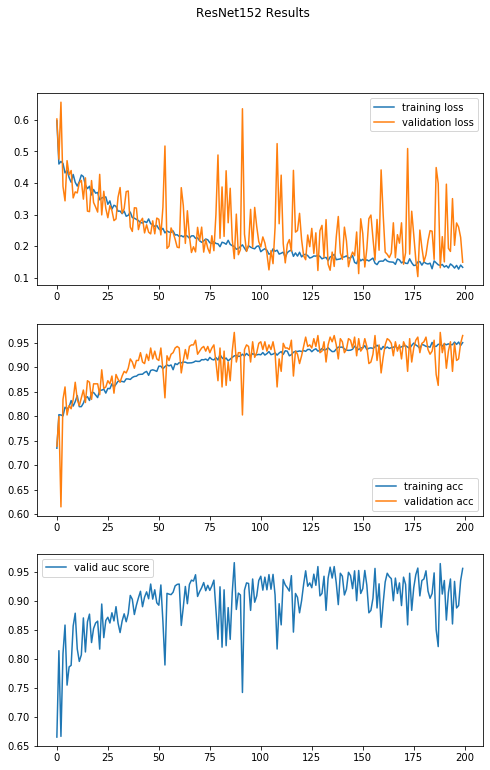

In [0]:
fig = plt.figure(figsize=(8, 20))

fig, (ax1, ax2, ax3) = plt.subplots(3, figsize=(8,12))
fig.suptitle('ResNet152 Results')

ax1.plot(res_train_loss, label='training loss')
ax1.plot(res_valid_loss, label='validation loss')
ax1.legend()

ax2.plot(res_train_acc, label='training acc')
ax2.plot(res_valid_acc, label='validation acc')
ax2.legend()

ax3.plot(res_valid_auc_score, label='valid auc score')
ax3.legend()

Epoch = 178 has the best results.

In [0]:
res_valid_acc[178-1], res_valid_auc_score[178-1]

(0.9617834394904459, 0.9563573883161512)

In [0]:
resnet = models.resnet152(num_classes=2)
model = resnet#.to(device)
model.load_state_dict(torch.load('best_models/resnet152_best_model_178.pth', map_location=torch.device('cpu')))

<All keys matched successfully>

In [0]:
res_proabs_stacked = history_resnet152_101['valid_probas_list'][78-1]
res_true_labels = history_resnet152_101['valid_truelabels_list'][78-1]
res_pred_labels = history_resnet152_101['valid_preds_list'][78-1]

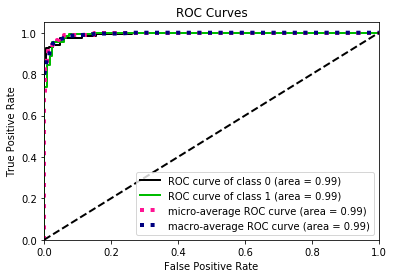

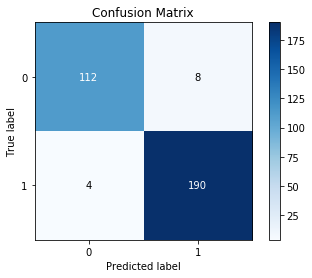

In [0]:
import scikitplot as skplt
skplt.metrics.plot_roc(res_true_labels, res_proabs_stacked)
skplt.metrics.plot_confusion_matrix(res_true_labels, res_pred_labels)

# ResNet(0: normal, 1: virus, 2: bacteria)

In [0]:
res_train_loss = history_resnet3['train_loss'] 
res_valid_loss = history_resnet3['valid_loss'] 
res_train_acc = history_resnet3['train_acc'] 
res_valid_acc = history_resnet3['valid_acc'] 

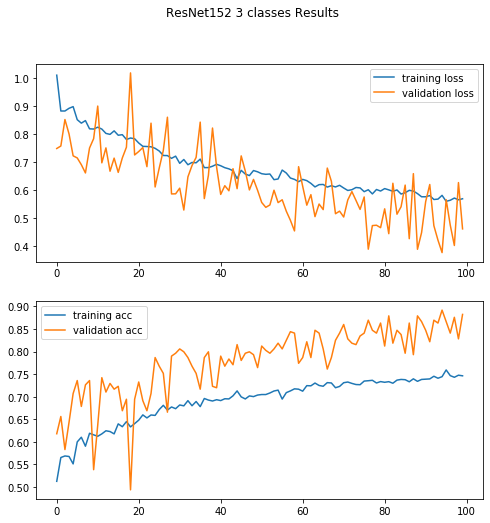

In [0]:
fig, (ax1, ax2) = plt.subplots(2, figsize=(8,8))
fig.suptitle('ResNet152 3 classes Results')

ax1.plot(res_train_loss, label='training loss')
ax1.plot(res_valid_loss, label='validation loss')
ax1.legend()

ax2.plot(res_train_acc, label='training acc')
ax2.plot(res_valid_acc, label='validation acc')
ax2.legend()

plt.savefig('ResNet152_3classestrain1.jpeg')

Epoch = 96 has the best results

In [0]:
res_valid_acc[96-1]

0.89171974522293


In [0]:
res_proabs_stacked = np.vstack(history_resnet3['valid_probas_list'])
res_true_labels = np.concatenate(history_resnet3['valid_truelabels_list'])
res_pred_labels = np.concatenate(history_resnet3['valid_preds_list'])

In [0]:
resnet = models.resnet152(num_classes=3)
model = resnet.to(device)
model.load_state_dict(torch.load('best_resnet.pth'))

<ipython-input-31-02bc424a3bc6>:12: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  data = Variable(data,volatile=True).type(torch.FloatTensor).cuda()
<ipython-input-31-02bc424a3bc6>:13: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  target = Variable(target,volatile=True).type(torch.LongTensor).cuda()
<ipython-input-32-1e93fb08aa70>:29: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  mean_tpr += interp(all_fpr, fpr[i], tpr[i])


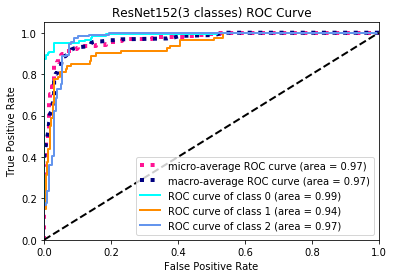

macro AUC for ResNet152 is:  0.9654059338896335


In [0]:
y_s, y_t=inference(model,valid_loader)
r_AUC = get_AUC(y_s, y_t, True)
print('macro AUC for ResNet152 is: ', r_AUC["macro"])

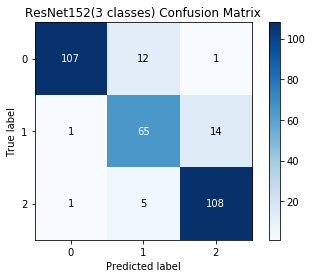

In [0]:
skplt.metrics.plot_confusion_matrix(res_true_labels, res_pred_labels, title = 'ResNet152(3 classes) Confusion Matrix')

# DenseNet

In [0]:
den_train_loss = history_densenet161['train_loss'] + history_densenet161_197['train_loss']
den_valid_loss = history_densenet161['valid_loss'] + history_densenet161_197['valid_loss']
den_train_acc = history_densenet161['train_acc'] + history_densenet161_197['train_acc']
den_valid_acc = history_densenet161['valid_acc'] + history_densenet161_197['valid_acc']
den_valid_auc_score = history_densenet161['valid_auc_score'] + history_densenet161_197['valid_auc_score']

<Figure size 576x1440 with 0 Axes>

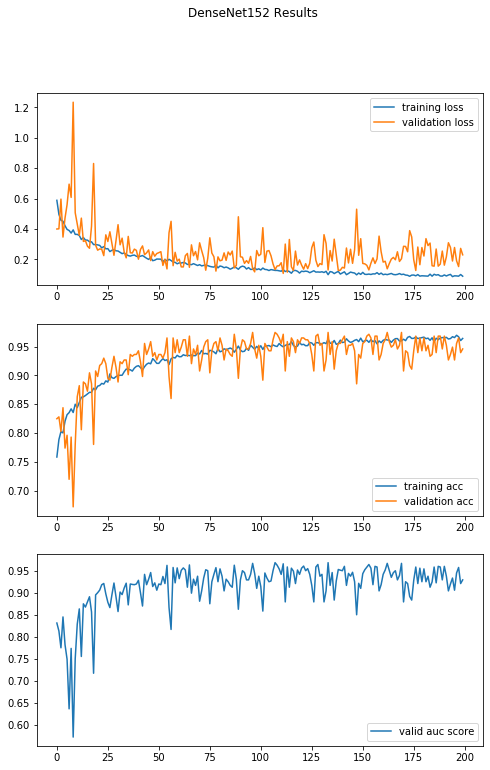

In [0]:
fig = plt.figure(figsize=(8, 20))

fig, (ax1, ax2, ax3) = plt.subplots(3, figsize=(8,12))
fig.suptitle('DenseNet152 Results')

ax1.plot(den_train_loss, label='training loss')
ax1.plot(den_valid_loss, label='validation loss')
ax1.legend()

ax2.plot(den_train_acc, label='training acc')
ax2.plot(den_valid_acc, label='validation acc')
ax2.legend()

ax3.plot(den_valid_auc_score, label='valid auc score')
ax3.legend()

Epoch = 198 has the best results.

In [0]:
den_valid_acc[198-1], den_valid_auc_score[198-1]

(0.964968152866242, 0.9573453608247423)

In [0]:
dense_proabs_stacked = history_densenet161_197['valid_probas_list'][1]
dense_true_labels = history_densenet161_197['valid_truelabels_list'][1]
dense_pred_labels = history_densenet161_197['valid_preds_list'][1]

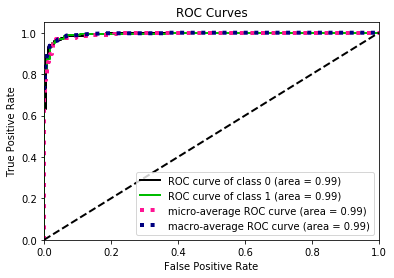

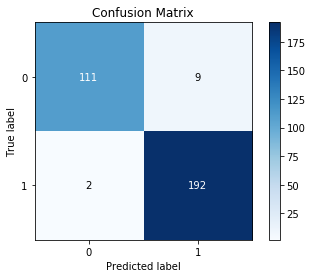

In [0]:
import scikitplot as skplt
skplt.metrics.plot_roc(dense_true_labels, dense_proabs_stacked)
skplt.metrics.plot_confusion_matrix(dense_true_labels, dense_pred_labels)

# DenseNet(0: normal, 1: virus, 2: bacteria)--Best Model in 3 Classes Classification

In [0]:
den_train_loss = history_densenet3['train_loss'] 
den_valid_loss = history_densenet3['valid_loss'] 
den_train_acc = history_densenet3['train_acc'] 
den_valid_acc = history_densenet3['valid_acc'] 


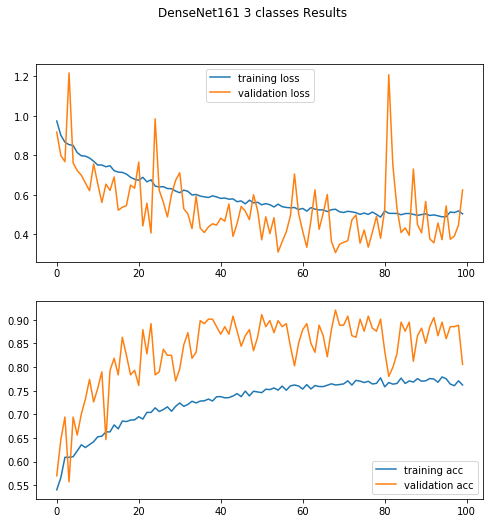

In [0]:
fig, (ax1, ax2) = plt.subplots(2, figsize=(8,8))
fig.suptitle('DenseNet161 3 classes Results')

ax1.plot(den_train_loss, label='training loss')
ax1.plot(den_valid_loss, label='validation loss')
ax1.legend()

ax2.plot(den_train_acc, label='training acc')
ax2.plot(den_valid_acc, label='validation acc')
ax2.legend()

plt.savefig('DenseNet161_3classestrain1.jpeg')

Epoch = 70 has the best results.

In [0]:
den_valid_acc[70-1]

0.9203821656050956


In [0]:
dense_proabs_stacked = np.vstack(history_densenet3['valid_probas_list'])
dense_true_labels = np.concatenate(history_densenet3['valid_truelabels_list'])
dense_pred_labels = np.concatenate(history_densenet3['valid_preds_list'])

In [0]:
densenet = models.densenet161(num_classes=3)
model = densenet.to(device)
model.load_state_dict(torch.load('best_densenet.pth'))

<ipython-input-37-02bc424a3bc6>:12: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  data = Variable(data,volatile=True).type(torch.FloatTensor).cuda()
<ipython-input-37-02bc424a3bc6>:13: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  target = Variable(target,volatile=True).type(torch.LongTensor).cuda()
<ipython-input-45-7d83bb6acf21>:29: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  mean_tpr += interp(all_fpr, fpr[i], tpr[i])


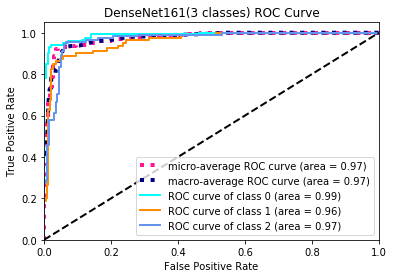

macro AUC for DenseNet161 is:  0.973436013261982


In [0]:
y_s, y_t=inference(model,valid_loader)
r_AUC = get_AUC(y_s, y_t, True)
print('macro AUC for DenseNet161 is: ', r_AUC["macro"])

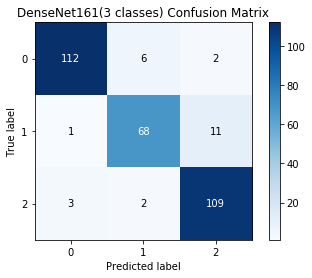

In [0]:
import scikitplot as skplt
skplt.metrics.plot_confusion_matrix(dense_true_labels, dense_pred_labels, title = 'DenseNet161(3 classes) Confusion Matrix')

## Evaliation on test set

In [0]:
dense_test_loss = history_densenet3_test['test_loss']
dense_test_acc = history_densenet3_test['test_acc']
dense_proabs_stacked = history_densenet3_test['probas_list']
dense_true_labels = history_densenet3_test['truelabels_list']
dense_pred_labels = history_densenet3_test['preds_list']

In [18]:
print('test loss is ', dense_test_loss, ', test accuracy is ', dense_test_acc)

test loss is 0.32030096073304454, test accuracy is 0.9129032258064517


In [0]:
import scikitplot as skplt
skplt.metrics.plot_roc(dense_true_labels, dense_proabs_stacked)
skplt.metrics.plot_confusion_matrix(dense_true_labels, dense_pred_labels)

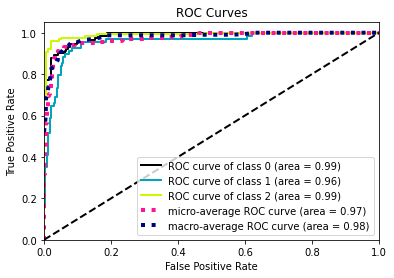

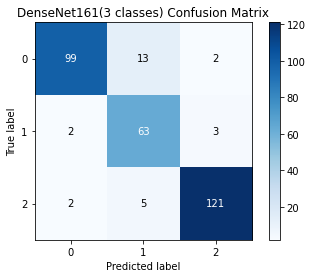

In [0]:
import scikitplot as skplt
skplt.metrics.plot_roc(true_labels, proabs_stacked)
skplt.metrics.plot_confusion_matrix(true_labels, pred_labels, title = 'DenseNet161(3 classes) Confusion Matrix')

# GoogLeNet

In [0]:
goo_train_loss = history_googlenet['train_loss'] 
goo_valid_loss = history_googlenet['valid_loss'] 
goo_train_acc = history_googlenet['train_acc'] 
goo_valid_acc = history_googlenet['valid_acc'] 
goo_valid_auc_score = history_googlenet['valid_auc_score'] 

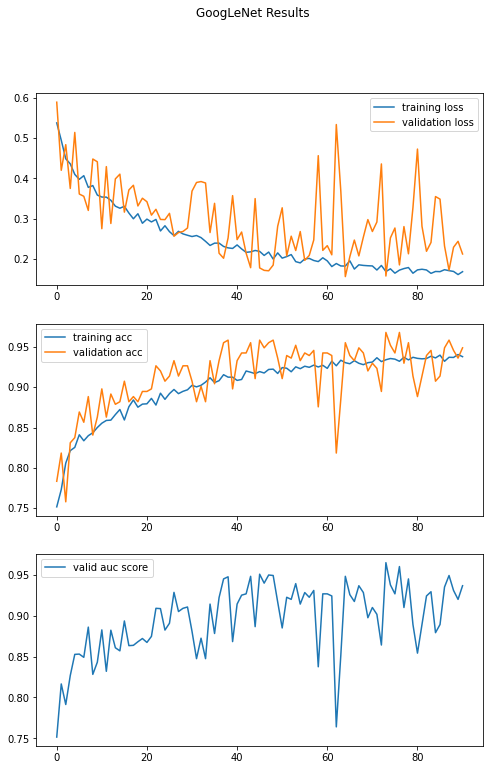

In [11]:
fig, (ax1, ax2, ax3) = plt.subplots(3, figsize=(8,12))
fig.suptitle('GoogLeNet Results')

ax1.plot(goo_train_loss, label='training loss')
ax1.plot(goo_valid_loss, label='validation loss')
ax1.legend()

ax2.plot(goo_train_acc, label='training acc')
ax2.plot(goo_valid_acc, label='validation acc')
ax2.legend()

ax3.plot(goo_valid_auc_score, label='valid auc score')
ax3.legend()

plt.savefig('GoogLeNet_train.jpeg')

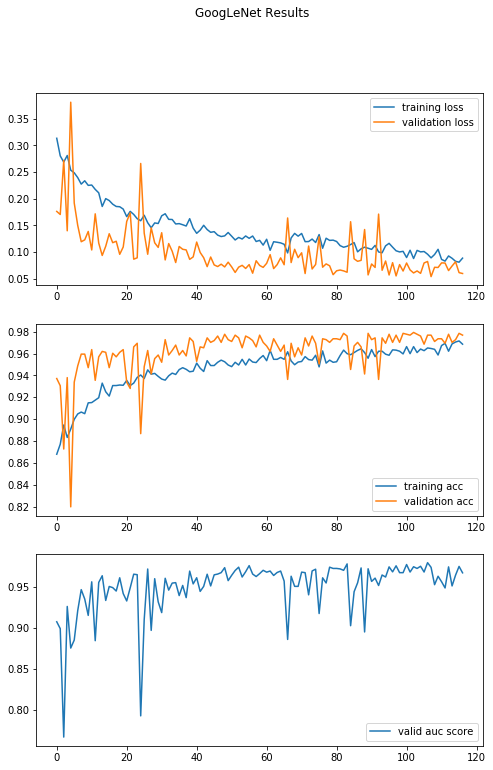

In [0]:
fig, (ax1, ax2, ax3) = plt.subplots(3, figsize=(8,12))
fig.suptitle('GoogLeNet Results')

ax1.plot(goo_train_loss, label='training loss')
ax1.plot(goo_valid_loss, label='validation loss')
ax1.legend()

ax2.plot(goo_train_acc, label='training acc')
ax2.plot(goo_valid_acc, label='validation acc')
ax2.legend()

ax3.plot(goo_valid_auc_score, label='valid auc score')
ax3.legend()

plt.savefig('GoogLeNet_train.jpeg')

*Epoch* = 74 has the best results

In [14]:
goo_valid_acc[74-1], goo_valid_auc_score[74-1]

(0.9681528662420382, 0.9646907216494846)

In [0]:
goo_proabs_stacked = history_googlenet['valid_probas_list'][74-1]
goo_true_labels = history_googlenet['valid_truelabels_list'][74-1]
goo_pred_labels = history_googlenet['valid_preds_list'][74-1]

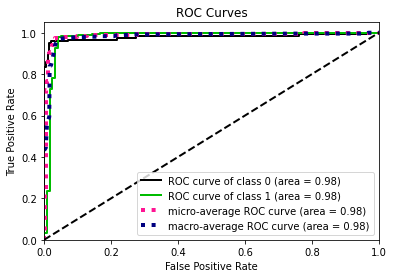

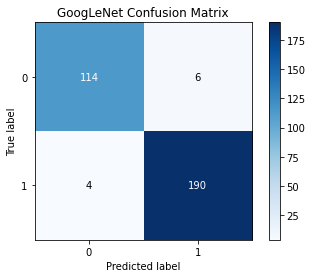

In [17]:
import scikitplot as skplt
skplt.metrics.plot_roc(goo_true_labels, goo_proabs_stacked)
skplt.metrics.plot_confusion_matrix(goo_true_labels, goo_pred_labels, title = 'GoogLeNet Confusion Matrix')

# GoogLeNet(0: normal, 1: virus, 2: bacteria)

In [0]:
goo_train_loss = history_googlenet3['train_loss'] 
goo_valid_loss = history_googlenet3['valid_loss'] 
goo_train_acc = history_googlenet3['train_acc'] 
goo_valid_acc = history_googlenet3['valid_acc'] 

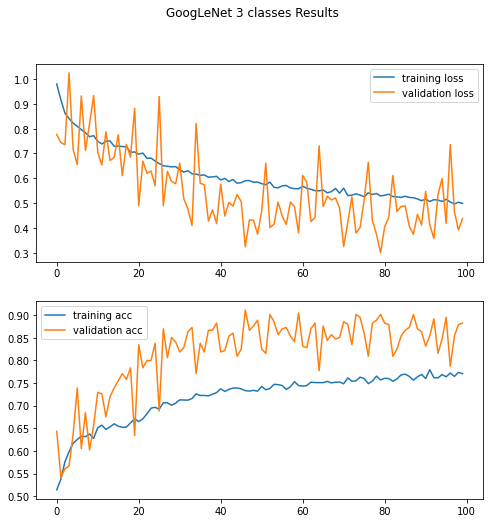

In [0]:
fig, (ax1, ax2) = plt.subplots(2, figsize=(8,8))
fig.suptitle('GoogLeNet 3 classes Results')

ax1.plot(goo_train_loss, label='training loss')
ax1.plot(goo_valid_loss, label='validation loss')
ax1.legend()

ax2.plot(goo_train_acc, label='training acc')
ax2.plot(goo_valid_acc, label='validation acc')
ax2.legend()

plt.savefig('GoogLeNet_3classestrain.jpeg')

Epoch = 47 has the best results.

In [0]:
goo_valid_acc[47-1]

0.910828025477707


In [0]:
google_proabs_stacked = np.vstack(history_googlenet3['valid_probas_list'])
google_true_labels = np.concatenate(history_googlenet3['valid_truelabels_list'])
google_pred_labels = np.concatenate(history_googlenet3['valid_preds_list'])

In [0]:
googlenet = models.googlenet()
googlenet.fc = nn.Linear(1024,3)
googlenet.aux_logits = False
model = googlenet.to(device)
model.load_state_dict(torch.load('best_googlenet3.pth'))

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  if sys.path[0] == '':
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:13: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  del sys.path[0]
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:29: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead


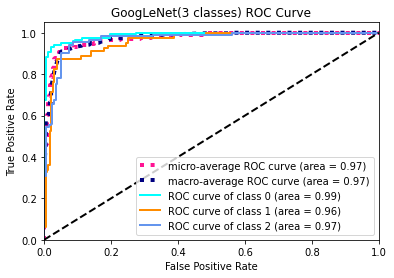

macro AUC for GoogLeNet is:  0.9734852920678794


In [0]:
y_s, y_t=inference(model,valid_loader)
r_AUC = get_AUC(y_s, y_t, True)
print('macro AUC for GoogLeNet is: ', r_AUC["macro"])

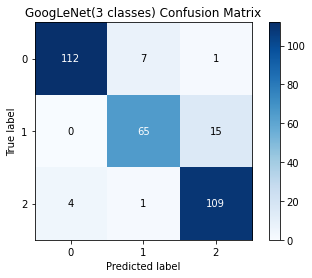

In [0]:
import scikitplot as skplt
skplt.metrics.plot_confusion_matrix(google_true_labels, google_pred_labels, title = 'GoogLeNet(3 classes) Confusion Matrix')

# Pretrained GoogLeNet

In [0]:
goo_pre_train_loss = history_googlenet_pretrained['train_loss'] 
goo_pre_valid_loss = history_googlenet_pretrained['valid_loss'] 
goo_pre_train_acc  = history_googlenet_pretrained['train_acc'] 
goo_pre_valid_acc  = history_googlenet_pretrained['valid_acc'] 
goo_pre_valid_auc_score = history_googlenet_pretrained['valid_auc_score']

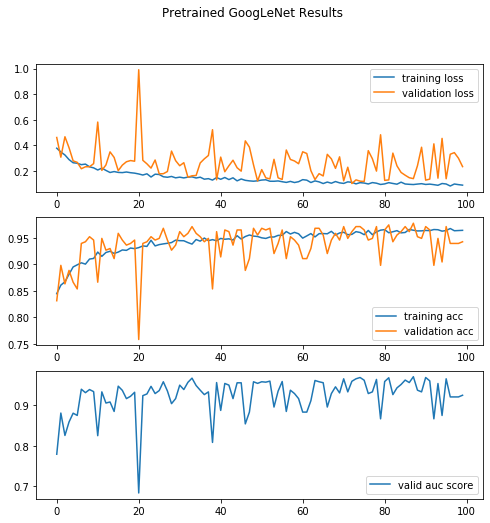

In [0]:
fig, (ax1, ax2, ax3) = plt.subplots(3, figsize=(8,8))
fig.suptitle('Pretrained GoogLeNet Results')

ax1.plot(goo_pre_train_loss, label='training loss')
ax1.plot(goo_pre_valid_loss, label='validation loss')
ax1.legend()

ax2.plot(goo_pre_train_acc, label='training acc')
ax2.plot(goo_pre_valid_acc, label='validation acc')
ax2.legend()

ax3.plot(goo_pre_valid_auc_score, label='valid auc score')
ax3.legend()

Epoch 73 has the best results.

In [0]:
goo_pre_valid_acc[73+1], goo_pre_valid_auc_score[73+1]

(0.9713375796178344, 0.9688573883161513)

In [0]:
goo_pre_proabs_stacked = history_googlenet_pretrained['valid_probas_list'][73+1]
goo_pre_true_labels = history_googlenet_pretrained['valid_truelabels_list'][73+1]
goo_pre_pred_labels = history_googlenet_pretrained['valid_preds_list'][73+1]

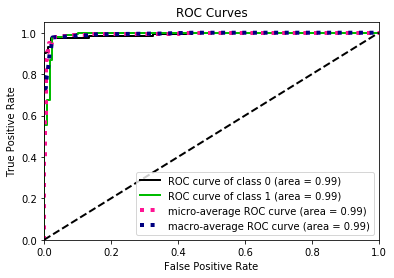

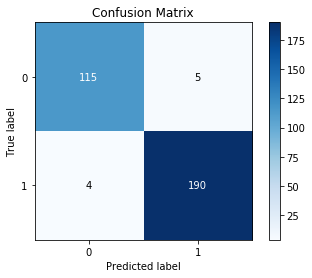

In [0]:
import scikitplot as skplt
skplt.metrics.plot_roc(goo_pre_true_labels, goo_pre_proabs_stacked)
skplt.metrics.plot_confusion_matrix(goo_pre_true_labels, goo_pre_pred_labels)

# Pretrained GoogLeNet 3 Classes

In [0]:
goo_3_pre_train_loss = history_googlenet_3_pretrained['train_loss'] 
goo_3_pre_valid_loss = history_googlenet_3_pretrained['valid_loss'] 
goo_3_pre_train_acc  = history_googlenet_3_pretrained['train_acc'] 
goo_3_pre_valid_acc  = history_googlenet_3_pretrained['valid_acc'] 
goo_3_pre_valid_auc_score = history_googlenet_3_pretrained['valid_auc_score']

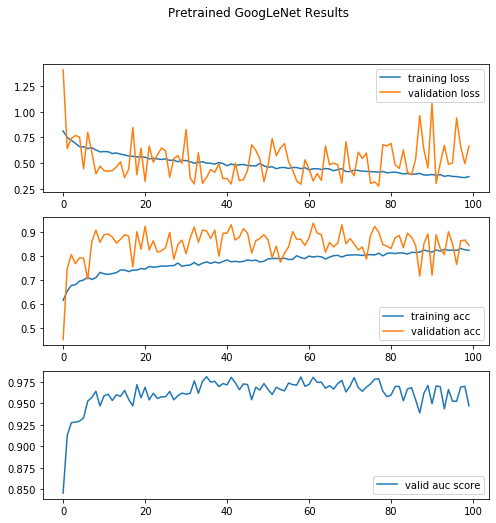

In [0]:
fig, (ax1, ax2, ax3) = plt.subplots(3, figsize=(8,8))
fig.suptitle('Pretrained GoogLeNet Results')

ax1.plot(goo_3_pre_train_loss, label='training loss')
ax1.plot(goo_3_pre_valid_loss, label='validation loss')
ax1.legend()

ax2.plot(goo_3_pre_train_acc, label='training acc')
ax2.plot(goo_3_pre_valid_acc, label='validation acc')
ax2.legend()

ax3.plot(goo_3_pre_valid_auc_score, label='valid auc score')
ax3.legend()

Epoch 78 has the best results.

In [0]:
goo_3_pre_valid_acc[78-1], goo_3_pre_valid_auc_score[78-1]

(0.8980891719745223, 0.9786686769005848)

In [0]:
goo_3_pre_proabs_stacked = history_googlenet_3_pretrained['valid_probas_list'][78-1]
goo_3_pre_true_labels = history_googlenet_3_pretrained['valid_truelabels_list'][78-1]
goo_3_pre_pred_labels = history_googlenet_3_pretrained['valid_preds_list'][78-1]

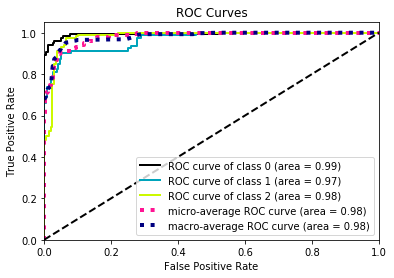

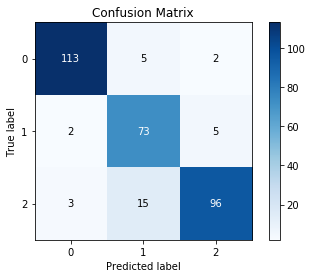

In [0]:
import scikitplot as skplt
skplt.metrics.plot_roc(goo_3_pre_true_labels, goo_3_pre_proabs_stacked)
skplt.metrics.plot_confusion_matrix(goo_3_pre_true_labels, goo_3_pre_pred_labels)